In [1]:
from dypac import Dypac
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
import time
from nilearn import datasets
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn import plotting
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr

Let's start by downloading a few subjects from the ADHD200 dataset.

In [2]:
n_subjects = 1
adhd_dataset = datasets.fetch_adhd(n_subjects)
epi_filename = adhd_dataset.func
# Also load a probabilistic grey matter segmentation
mni = datasets.fetch_icbm152_2009()

/home/pbellec/env/dypac/lib/python3.7/site-packages/nilearn/datasets/func.py:439: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


Now we run dypac. First we specify the model, with the main relevant options. Then we fit the model on the ADHD data.

In [3]:
model = Dypac(n_clusters=10, grey_matter=mni.gm, std_grey_matter=3, n_states=20, verbose=1, n_init=1, n_init_aggregation=1, n_replications=20, 
              detrend=True, smoothing_fwhm=5, standardize=True, n_batch=1, threshold_sim=0)
model.fit(epi_filename)

[MultiNiftiMasker.fit] Loading data from [/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz]
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


Replicating clusters in data #0: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Consensus clustering.


Trimming states: 100%|██████████| 20/20 [00:00<00:00, 226.02it/s]


Dypac(detrend=True,
      grey_matter='/home/pbellec/nilearn_data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_gm_tal_nlin_sym_09a.nii.gz',
      high_pass=None, low_pass=None, mask=None, mask_args=None,
      mask_strategy='epi', max_iter=30, memory=Memory(location=None),
      memory_level=1, n_batch=1, n_clusters=10, n_init=1, n_init_aggregation=1,
      n_replications=20, n_states=20,
      random_state=RandomState(MT19937) at 0x7FDC4533E380, smoothing_fwhm=5,
      standardize=True, std_grey_matter=3, subsample_size=30, t_r=None,
      target_affine=None, target_shape=None, threshold_sim=0, verbose=1)

In [5]:
weights = model.transform(epi_filename)

[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image('/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals


/home/pbellec/env/dypac/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



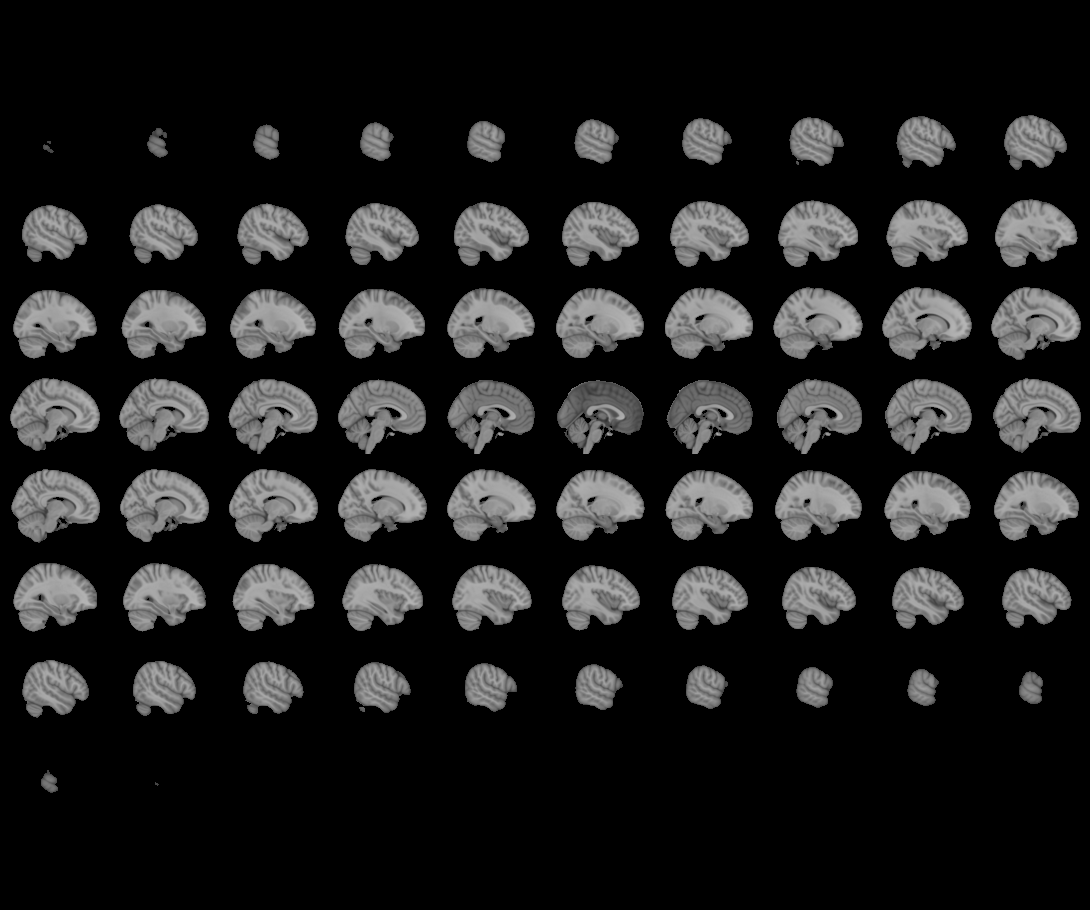
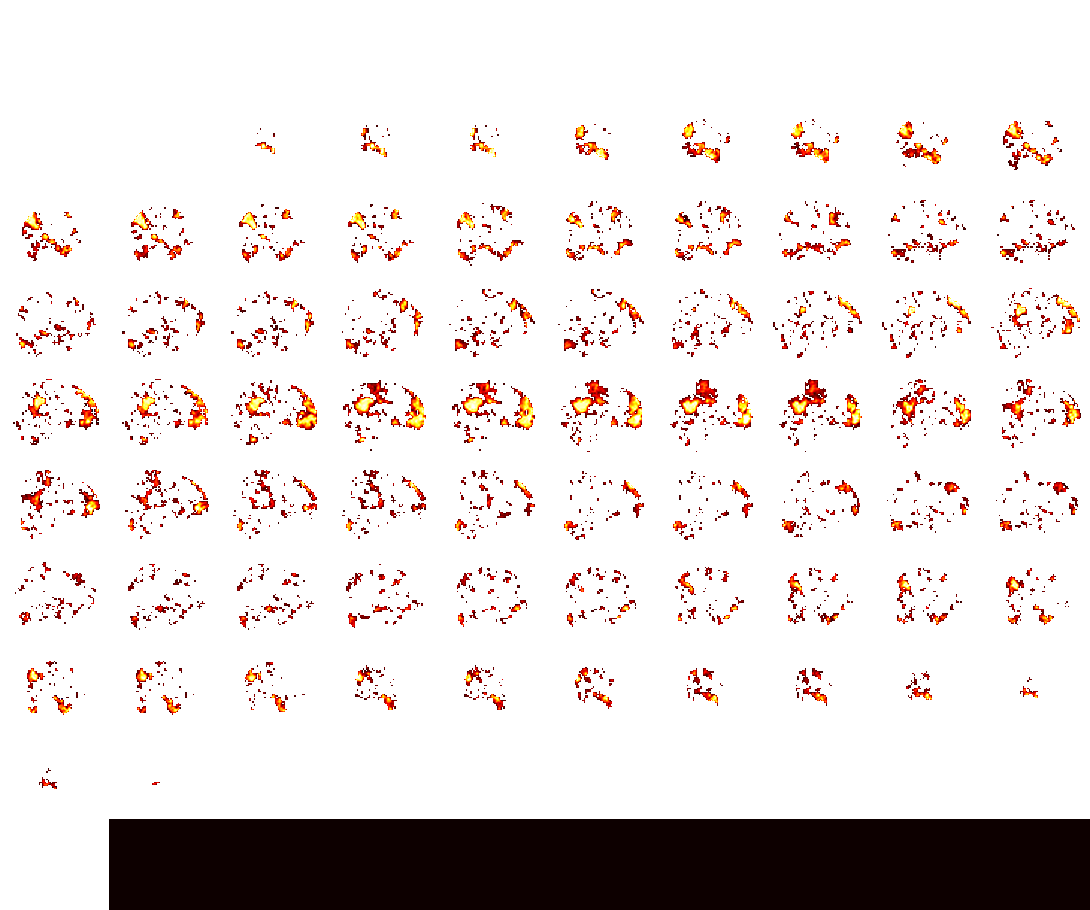

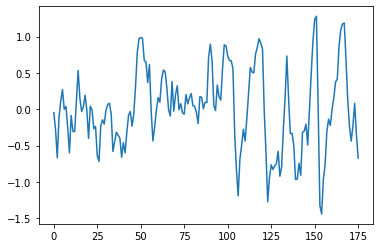

In [23]:
num_comp = 5
comp = model.masker_.inverse_transform(model.components_[num_comp,:].todense())
plt.plot(weights[:, num_comp+1])
plotting.view_img(comp, threshold=0.1, vmax=1, title="Dwell time: {dt}".format(dt=model.dwell_time_[num_comp]))

Save model in a pickle file

In [25]:
import pickle
hf = open('model.pickle','wb')
pickle.dump(model, hf)
hf.close()